In [103]:
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.cross_validation import cross_val_score


In [104]:
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final=pd.read_sql_query(""" SELECT * FROM Reviews  """, conn) 

In [105]:
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)
# Sorting data based on time
final["Time"] = pd.to_datetime(final["Time"], unit = "s")
final= final.sort_values(by = "Time")

In [106]:
from sklearn.model_selection import train_test_split
X = final["CleanedText"]
y = final["Score"].map(lambda x: 1 if x == 'positive' else 0)
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle='false')
print(X_train.shape, y_train.shape, x_test.shape)

(61442,) (61442,) (26333,)


In [107]:
bow = CountVectorizer(binary=True)
X_train = bow.fit_transform(X_train)
X_train

<61442x28786 sparse matrix of type '<class 'numpy.int64'>'
	with 1939859 stored elements in Compressed Sparse Row format>

In [108]:
x_test = bow.transform(x_test)
x_test.shape
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)


In [109]:
from sklearn.preprocessing import StandardScaler
X_train=StandardScaler(with_mean=False).fit_transform(X_train)
x_test=StandardScaler(with_mean=False).fit_transform(x_test)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 29.4min finished


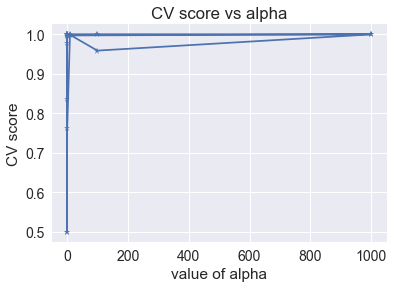

Best HyperParameter:  {'C': 0.01, 'penalty': 'l1'}
Best Auc score: 91.91%


In [110]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, make_scorer

c=[1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001,1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]
clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001],
             'penalty':['l1','l2']} 


tscv = TimeSeriesSplit(n_splits=3) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='roc_auc')
gsv.fit(X_train,y_train)
scores =gsv.cv_results_['mean_train_score']
plt.plot(c, scores, marker = '*') 
plt.title("CV score vs alpha")
plt.xlabel('value of alpha')
plt.ylabel('CV score')
plt.show()
print("Best HyperParameter: ",gsv.best_params_)
print("Best Auc score: %.2f%%"%(gsv.best_score_*100))

In [111]:
gsv.grid_scores_

[mean: 0.81950, std: 0.01707, params: {'C': 1000, 'penalty': 'l1'},
 mean: 0.82614, std: 0.00936, params: {'C': 1000, 'penalty': 'l2'},
 mean: 0.83171, std: 0.02170, params: {'C': 100, 'penalty': 'l1'},
 mean: 0.83100, std: 0.01229, params: {'C': 100, 'penalty': 'l2'},
 mean: 0.84647, std: 0.02359, params: {'C': 10, 'penalty': 'l1'},
 mean: 0.83456, std: 0.01516, params: {'C': 10, 'penalty': 'l2'},
 mean: 0.86952, std: 0.01090, params: {'C': 1, 'penalty': 'l1'},
 mean: 0.84475, std: 0.01029, params: {'C': 1, 'penalty': 'l2'},
 mean: 0.91147, std: 0.00056, params: {'C': 0.1, 'penalty': 'l1'},
 mean: 0.86316, std: 0.00533, params: {'C': 0.1, 'penalty': 'l2'},
 mean: 0.91915, std: 0.01146, params: {'C': 0.01, 'penalty': 'l1'},
 mean: 0.88886, std: 0.00213, params: {'C': 0.01, 'penalty': 'l2'},
 mean: 0.76079, std: 0.07240, params: {'C': 0.001, 'penalty': 'l1'},
 mean: 0.90524, std: 0.00713, params: {'C': 0.001, 'penalty': 'l2'},
 mean: 0.50000, std: 0.00000, params: {'C': 0.0001, 'penalty

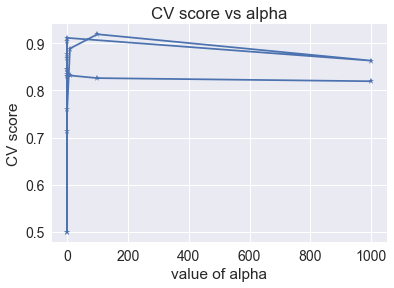


The accuracy of the lr for c = 0 is 90.377093%

The f1 score of the lr for c = 0 is 81.581964%

The recall score of the lr for c = 0 is 80.319032%

The precision score of the lr for c = 0 is 83.044683%


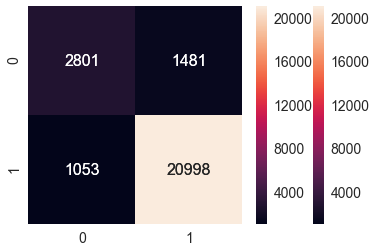

In [112]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
clf = LogisticRegression(C= 0.1, penalty= 'l1')
clf.fit(X_train,y_train)
pred = clf.predict(x_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
f1=f1_score(y_test, pred,average= 'macro')*100
r=recall_score(y_test, pred,average= 'macro')*100
p=precision_score(y_test, pred,average= 'macro')*100
c=[1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001,1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]    
scores =gsv.cv_results_['mean_test_score']
plt.plot(c, scores, marker = '*') 
plt.title("CV score vs alpha")
plt.xlabel('value of alpha')
plt.ylabel('CV score')
plt.show()
print('\nThe accuracy of the lr for c = %d is %f%%' % (0.1, acc))
print('\nThe f1 score of the lr for c = %d is %f%%' % (0.1, f1))
print('\nThe recall score of the lr for c = %d is %f%%' % (0.1, r))
print('\nThe precision score of the lr for c = %d is %f%%' % (0.1, p))
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [113]:
clf = LogisticRegression(C= 1000, penalty= 'l1')
clf.fit(X_train,y_train)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 15221


In [114]:
clf = LogisticRegression(C= 100, penalty= 'l1')
clf.fit(X_train,y_train)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 14292


In [115]:
clf = LogisticRegression(C= 10, penalty= 'l1')
clf.fit(X_train,y_train)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 13408


In [116]:
clf = LogisticRegression(C= 1, penalty= 'l1')
clf.fit(X_train,y_train)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 12576


# OBSERVATION
As lambda increases or c(inverse of lambda) decreases sparsity increases

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 14.0min finished


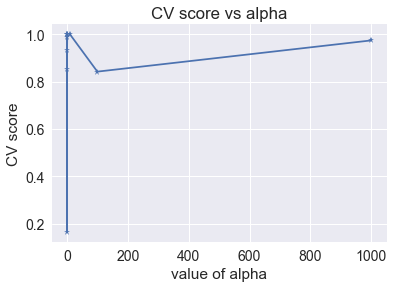

Best HyperParameter:  {'penalty': 'l2', 'C': 0.001}
Best Accuracy: 90.43%


In [117]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
c=[1000,100,10,1,0.5,0.1,0.01,0.001,0.0001,0.00001]
clf = LogisticRegression()
#params we need to try on classifier
param_grid = { 'C':[1000,100,10,1,0.5,0.1,0.01,0.001,0.0001,0.00001],
              'penalty':['l1','l2']}
tscv = TimeSeriesSplit(n_splits=3) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='roc_auc')
gsv.fit(X_train,y_train)
scores =gsv.cv_results_['mean_train_score']
plt.plot(c, scores, marker = '*') 
plt.title("CV score vs alpha")
plt.xlabel('value of alpha')
plt.ylabel('CV score')
plt.show()

print("Best HyperParameter: ",gsv.best_params_)
print("Best auc score: %.2f%%"%(gsv.best_score_*100))

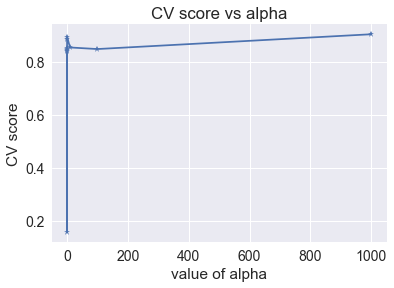


The accuracy of the lr for c = 0 is 90.380891%

The f1 score of the lr for c = 0 is 81.587383%

The recall score of the lr for c = 0 is 80.321300%

The precision score of the lr for c = 0 is 83.054261%


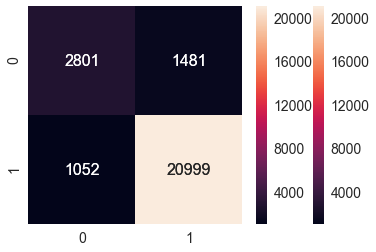

In [118]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
clf = LogisticRegression(C= 0.1, penalty= 'l1')
clf.fit(X_train,y_train)
pred = clf.predict(x_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
f1=f1_score(y_test, pred,average= 'macro')*100
r=recall_score(y_test, pred,average= 'macro')*100
p=precision_score(y_test, pred,average= 'macro')*100
    
scores =gsv.cv_results_['mean_test_score']
plt.plot(c, scores, marker = '*') 
plt.title("CV score vs alpha")
plt.xlabel('value of alpha')
plt.ylabel('CV score')
plt.show()

print('\nThe accuracy of the lr for c = %d is %f%%' % (0.1, acc))
print('\nThe f1 score of the lr for c = %d is %f%%' % (0.1, f1))
print('\nThe recall score of the lr for c = %d is %f%%' % (0.1, r))
print('\nThe precision score of the lr for c = %d is %f%%' % (0.1, p))
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [119]:
from scipy.sparse import find
#Weights before adding random noise
weights1 = find(clf.coef_[0])[2]
print(weights1[:50])

[-7.81515182e-03  7.39960150e-02 -1.14144632e-02  9.67046795e-04
  2.08829916e-03  9.11605851e-03 -2.40605659e-03  1.61131004e-02
 -1.02058780e-01  2.80737830e-03  7.19278442e-03  1.60374249e-02
  3.04410059e-02  6.59043704e-02  3.79794982e-03 -5.76927936e-03
 -1.03443611e-02  1.06540910e-02  9.66718053e-02  9.23701756e-03
  6.02995901e-02  9.68556530e-03 -4.11974309e-03 -1.56714481e-02
 -1.63928574e-02 -8.23295876e-03  1.00338974e-02 -6.98046643e-03
  3.32385785e-05  3.74999084e-03 -2.41008798e-02  1.57184932e-02
  3.00938066e-03 -1.70358355e-02  3.60680164e-02  3.37547527e-02
  2.10983813e-03  1.34274235e-02  1.46401679e-02  5.56268680e-03
 -1.30499796e-02  9.70866100e-02  7.13601026e-02 -3.24889923e-02
 -4.50611445e-02  1.48763058e-02 -6.61103574e-02 -4.45055180e-03
  1.92804520e-03  2.45903026e-02]


In [120]:
X_train_t = X_train
#Random noise
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_train_t)[0].size,))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(X_train_t)

#Introducing random noise to non-zero datapoints
X_train_t[a,b] = epsilon + X_train_t[a,b]

In [121]:
#Training on train data having random noise
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.1, penalty= 'l1')
clf.fit(X_train_t,y_train)
weights2 = find(clf.coef_[0])[2]
print(weights2[:50])

[-0.00516887  0.07402844 -0.01141558  0.00096132  0.01443633  0.00909876
 -0.00448801  0.01610631 -0.1020607   0.00280007  0.00718928  0.01609118
  0.0301497   0.06594617  0.00379984 -0.01169039 -0.01029749  0.01065015
  0.09662534  0.00923486  0.06026709  0.00969417 -0.00410804 -0.01570677
 -0.01637659 -0.00816224  0.0100437  -0.00698665  0.00023674  0.00377224
  0.00612537 -0.02403955  0.01572824  0.00307971 -0.01718973  0.03602188
  0.03378336  0.00214804  0.01340376  0.01460484  0.01421241 -0.0131278
  0.09707327  0.0713401  -0.0324693  -0.04508979  0.01486192 -0.06615405
  0.00192172  0.02458114]


In [127]:
weights_diff = (abs(weights1[0:10055] - weights2[0:10055])/weights1[0:10055]) * 100
print(weights_diff[np.where(weights_diff > 30)].size)

4972


# OBSERVATION
2868 features have weight changes greater than  30% . Features are multicollinear. 

In [128]:
clf = LogisticRegression(C= 0.1, penalty= 'l1')
clf.fit(X_train,y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [129]:
def show_most_informative_features(vectorizer, clf, n=25):
    d = {}
    a=0
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        d[a]=fn_1
        a+=1
    
show_most_informative_features(bow,clf)



			Positive						Negative
________________________________________________________________________________________________
	-0.3969	disappoint     				0.8314	great          
	-0.3298	worst          				0.6745	best           
	-0.2873	terribl        				0.5776	love           
	-0.2660	aw             				0.5634	delici         
	-0.2610	horribl        				0.5415	perfect        
	-0.2352	stick          				0.5331	excel          
	-0.2340	thought        				0.4251	good           
	-0.2337	tast           				0.4130	nice           
	-0.2251	return         				0.4008	amaz           
	-0.2192	hope           				0.3805	favorit        
	-0.2178	bad            				0.3423	awesom         
	-0.2058	bland          				0.3084	wonder         
	-0.2032	wast           				0.2881	easi           
	-0.1981	threw          				0.2802	smooth         
	-0.1975	didnt          				0.2783	tasti          
	-0.1973	money          				0.2696	thank          
	-0.1913	disgust        				0.2683	without        
	-0.1879	s

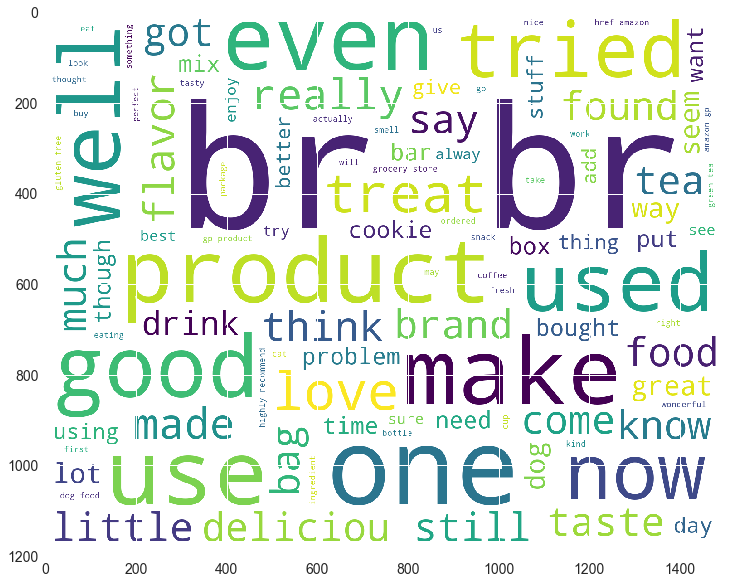

In [138]:
wc = WordCloud(max_words=1000, margin=10, background_color='white',
               scale=3, relative_scaling = 0.5, width=500, height=400,
               random_state=1).generate(' '.join(final['Text']))

plt.figure(figsize=(20,10))
plt.imshow(wc)

         
#wc.to_file("/wordcloud.png")

In [140]:
X = final["CleanedText"]
y = final["Score"].map(lambda x: 1 if x == 'positive' else 0)
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42,shuffle='false')
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(61442,) (26333,) (61442,) (26333,)


In [141]:
tf_idf_vect = TfidfVectorizer()
X_train = tf_idf_vect.fit_transform(X_train)

In [142]:
x_test = tf_idf_vect.transform(x_test)


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  1.1min finished


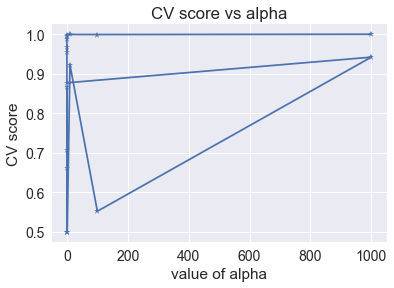

Best HyperParameter:  {'C': 1, 'penalty': 'l2'}
Best auc score: 93.95%


In [145]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=3) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='roc_auc')
gsv.fit(X_train,y_train)
c=[1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001,1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]    
scores =gsv.cv_results_['mean_train_score']
plt.plot(c, scores, marker = '*') 
plt.title("CV score vs alpha")
plt.xlabel('value of alpha')
plt.ylabel('CV score')
plt.show()
print("Best HyperParameter: ",gsv.best_params_)
print("Best auc score: %.2f%%"%(gsv.best_score_*100))

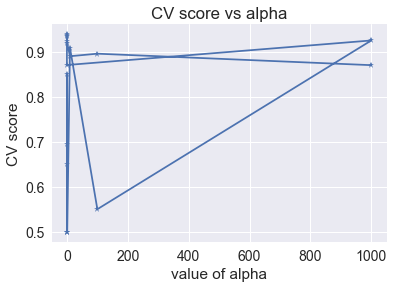


The accuracy of the lr for c = 10 is 91.812555%

The f1 score of the lr for c = 10 is 83.838341%

The recall score of the lr for c = 10 is 81.543100%

The precision score of the lr for c = 10 is 86.789784%


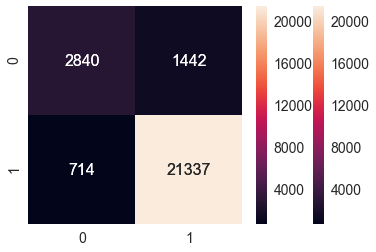

In [144]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train,y_train)
pred = clf.predict(x_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
f1=f1_score(y_test, pred,average= 'macro')*100
r=recall_score(y_test, pred,average= 'macro')*100
p=precision_score(y_test, pred,average= 'macro')*100
    
c=[1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001,1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]    
scores =gsv.cv_results_['mean_test_score']
plt.plot(c, scores, marker = '*') 
plt.title("CV score vs alpha")
plt.xlabel('value of alpha')
plt.ylabel('CV score')
plt.show()
print('\nThe accuracy of the lr for c = %d is %f%%' % (10, acc))
print('\nThe f1 score of the lr for c = %d is %f%%' % (10, f1))
print('\nThe recall score of the lr for c = %d is %f%%' % (10, r))
print('\nThe precision score of the lr for c = %d is %f%%' % (10, p))
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

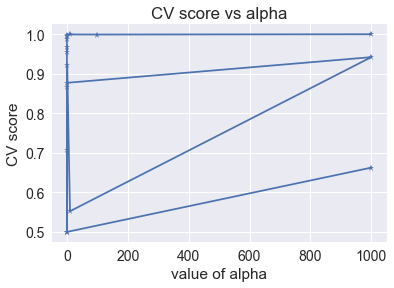

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   42.3s finished


Best HyperParameter:  {'penalty': 'l2', 'C': 10}
Best auc score: 93.71%


In [147]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = { 'C':[1000,100,10,1,0.5,0.1,0.01,0.001,0.0001],
              'penalty':['l1','l2']}
c=[1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001,1000,10,1,0.1,0.01,0.001,0.0001,0.00001,1000]    
scores =gsv.cv_results_['mean_train_score']
plt.plot(c, scores, marker = '*') 
plt.title("CV score vs alpha")
plt.xlabel('value of alpha')
plt.ylabel('CV score')
plt.show()
tscv = TimeSeriesSplit(n_splits=3) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='roc_auc')
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best auc score: %.2f%%"%(gsv.best_score_*100))

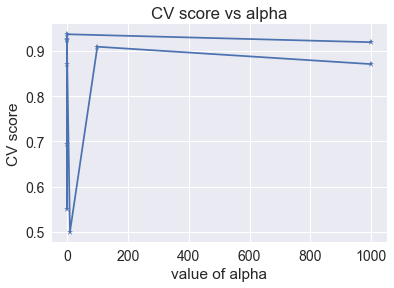


The accuracy of the lr for c = 10 is 91.812555%

The f1 score of the lr for c = 10 is 83.838341%

The recall score of the lr for c = 10 is 81.543100%

The precision score of the lr for c = 10 is 86.789784%


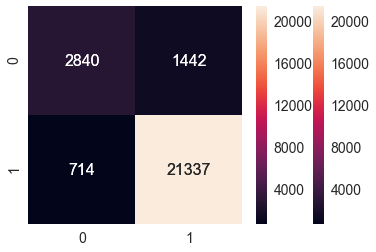

In [148]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train,y_train)
pred = clf.predict(x_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
f1=f1_score(y_test, pred,average= 'macro')*100
r=recall_score(y_test, pred,average= 'macro')*100
p=precision_score(y_test, pred,average= 'macro')*100
c=[1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001,1000]    
scores =gsv.cv_results_['mean_test_score']
plt.plot(c, scores, marker = '*') 
plt.title("CV score vs alpha")
plt.xlabel('value of alpha')
plt.ylabel('CV score')
plt.show()    

print('\nThe accuracy of the lr for c = %d is %f%%' % (10, acc))
print('\nThe f1 score of the lr for c = %d is %f%%' % (10, f1))
print('\nThe recall score of the lr for c = %d is %f%%' % (10, r))
print('\nThe precision score of the lr for c = %d is %f%%' % (10, p))
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [149]:
from scipy.sparse import find
#Weights before adding random noise
weights1 = find(clf.coef_[0])[2]
print(weights1[:50])


[ 2.41955703e-03  1.97417771e-02  2.31498442e-02 -6.48378072e-01
  2.31498442e-02  7.87724437e-02  2.99941135e-03  1.10221819e-02
 -7.34387075e-01  1.80899309e-03  2.08922237e-02  4.41265464e-01
  2.48075328e-02  1.37949011e-01 -2.07623166e-02  1.03919116e-02
  4.76129814e-03  2.89031103e-02  1.65128268e+00 -7.07244192e-02
  2.89404060e-01  7.28888423e-03  3.27688403e-03  1.41520108e-01
  7.04763430e-01  2.79752243e-01  1.08934130e+00  7.46495740e-02
  3.43977092e-01 -3.63600885e-01 -6.27473522e-01  5.25873560e-02
 -5.23205369e-01 -1.34608158e-01 -3.11232594e-01  9.17825720e-01
  1.45044638e-01  1.10534942e-02  1.00729937e+00 -1.28159151e+00
  5.16644033e-01  3.31352958e-02 -1.85810408e+00  2.72746205e-02
  1.65094079e-01 -9.90111327e-01 -3.75473050e-01  6.78040783e-01
  6.68884067e-03  2.48160987e-01]


In [150]:
X_train_t = X_train
#Random noise
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_train_t)[0].size,))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(X_train_t)

#Introducing random noise to non-zero datapoints
X_train_t[a,b] = epsilon + X_train_t[a,b]
#Training on train data having random noise
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train_t,y_train)
weights2 = find(clf.coef_[0])[2]
print(weights2[:50])
weights_diff = (abs(weights1 - weights2)/weights1) * 100
print(weights_diff[np.where(weights_diff > 30)].size)

[ 2.42282319e-03  1.97475232e-02  2.31931612e-02 -6.48751431e-01
  2.31709296e-02  7.88266640e-02  2.98620242e-03  1.10196473e-02
 -7.34822264e-01  1.80949608e-03  2.09114997e-02  4.41681506e-01
  2.48807655e-02  1.38093977e-01 -2.08101924e-02  1.03959321e-02
  4.76639984e-03  2.89299145e-02  1.65096570e+00 -7.07836590e-02
  2.89301807e-01  7.28635564e-03  3.28127429e-03  1.41589296e-01
  7.04546613e-01  2.79770775e-01  1.08950807e+00  7.47285213e-02
  3.44099419e-01 -3.63004634e-01 -6.27763492e-01  5.26150940e-02
 -5.23214518e-01 -1.34684508e-01 -3.11197686e-01  9.18301377e-01
  1.45012956e-01  1.11011044e-02  1.00676347e+00 -1.28118656e+00
  5.17390046e-01  3.31908017e-02 -1.85748745e+00  2.72573320e-02
  1.65093362e-01 -9.90831443e-01 -3.75249258e-01  6.77754771e-01
  6.69392262e-03  2.48347197e-01]
6


# OBSERVATION
13 features have weight changes greater than  30% . Features are multicollinear.

In [151]:
clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train,y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [152]:
show_most_informative_features(tf_idf_vect,clf)

			Positive						Negative
________________________________________________________________________________________________
	-12.8405	worst          				14.4278	great          
	-10.2544	terribl        				12.7161	delici         
	-10.0897	disappoint     				12.4700	best           
	-9.5277	aw             				11.5690	perfect        
	-8.5307	horribl        				11.1438	excel          
	-8.1608	disgust        				11.0346	amaz           
	-8.0861	bland          				9.6679	love           
	-8.0594	tasteless      				8.8864	worri          
	-7.5567	yuck           				8.8184	nice           
	-7.5036	undrink        				8.6441	beat           
	-7.2366	threw          				8.5435	awesom         
	-7.1030	decept         				7.9128	good           
	-7.0967	refund         				7.7886	skeptic        
	-7.0403	cancel         				7.6525	yummi          
	-6.8907	return         				7.6049	hook           
	-6.8175	flavorless     				7.5235	favorit        
	-6.7922	unfortun       				7.2559	smooth         
	

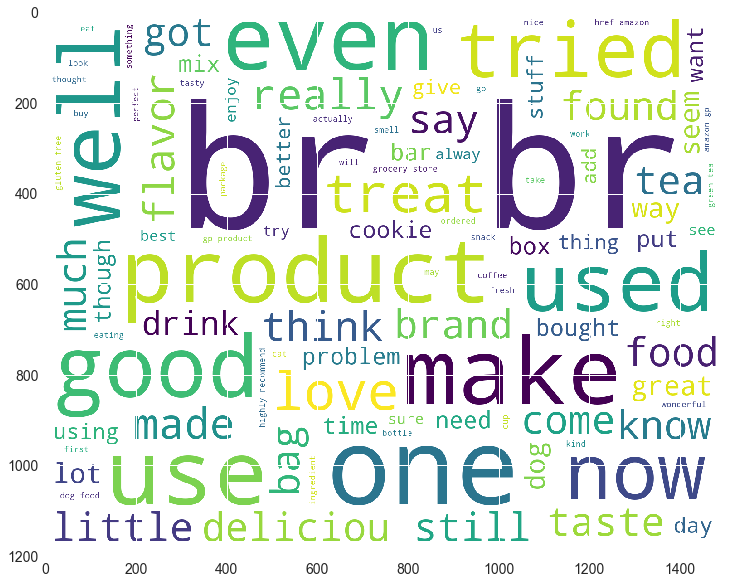

In [153]:
wc = WordCloud(max_words=1000, margin=10, background_color='white',
               scale=3, relative_scaling = 0.5, width=500, height=400,
               random_state=1).generate(' '.join(final['Text']))

plt.figure(figsize=(20,10))
plt.imshow(wc)

         
#wc.to_file("/wordcloud.png")

In [154]:
from sklearn.model_selection import train_test_split
X = final["Text"]
y = final["Score"].map(lambda x: 1 if x == 'positive' else 0)
X_train, x_test, y_train, y_test =train_test_split(X, y.values, test_size = 0.3, shuffle='false')
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(61442,) (26333,) (61442,) (26333,)


In [155]:
list_of_sent=[]
#for sent in final_40k['Text'].values:
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
for sent in X_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
import gensim
list_of_sent_test = []
#for sent in final_40k['Text'].values:
for sent in x_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)    

In [156]:
import gensim
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [157]:
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

61442
50
26333
50


In [158]:
X_train = sent_vectors
x_test = sent_vectors_test

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  3.8min finished


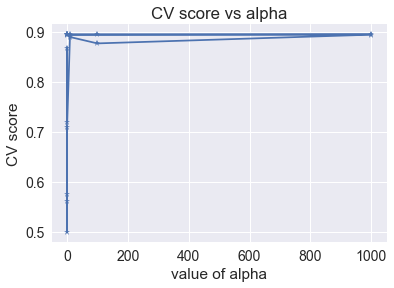

Best HyperParameter:  {'C': 1000, 'penalty': 'l2'}
Best auc score: 89.21%


In [160]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=3) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='roc_auc')
gsv.fit(X_train,y_train)
c=[1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001,1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]    
scores =gsv.cv_results_['mean_train_score']
plt.plot(c, scores, marker = '*') 
plt.title("CV score vs alpha")
plt.xlabel('value of alpha')
plt.ylabel('CV score')
plt.show()
print("Best HyperParameter: ",gsv.best_params_)
print("Best auc score: %.2f%%"%(gsv.best_score_*100))

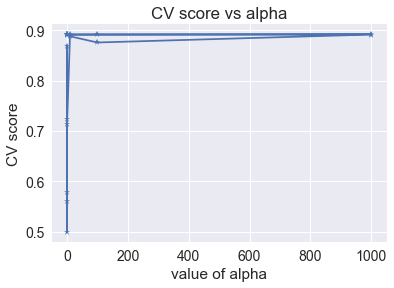


The accuracy of the lr for c = 10 is 87.540349%

The f1 score of the lr for c = 10 is 72.797266%

The recall score of the lr for c = 10 is 69.625887%

The precision score of the lr for c = 10 is 78.805204%


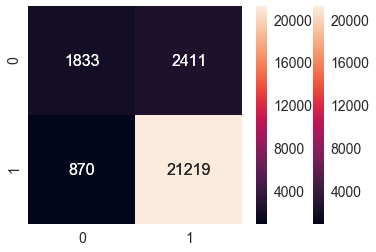

In [161]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
clf = LogisticRegression(C= 1000, penalty= 'l2')
clf.fit(X_train,y_train)
pred = clf.predict(x_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
f1=f1_score(y_test, pred,average= 'macro')*100
r=recall_score(y_test, pred,average= 'macro')*100
p=precision_score(y_test, pred,average= 'macro')*100
c=[1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001,1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]    
scores =gsv.cv_results_['mean_test_score']
plt.plot(c, scores, marker = '*') 
plt.title("CV score vs alpha")
plt.xlabel('value of alpha')
plt.ylabel('CV score')
plt.show()    

print('\nThe accuracy of the lr for c = %d is %f%%' % (10, acc))
print('\nThe f1 score of the lr for c = %d is %f%%' % (10, f1))
print('\nThe recall score of the lr for c = %d is %f%%' % (10, r))
print('\nThe precision score of the lr for c = %d is %f%%' % (10, p))
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.3min finished


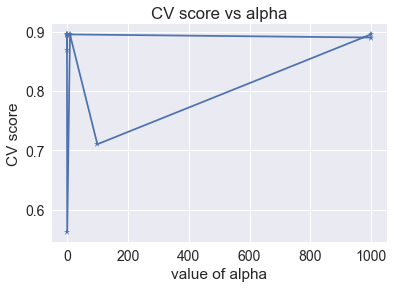

Best HyperParameter:  {'penalty': 'l2', 'C': 100}
Best Auc score: 89.21%


In [162]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = { 'C':[1000,100,10,1,0.5,0.1,0.01,0.001,0.0001],
              'penalty':['l1','l2']}
tscv = TimeSeriesSplit(n_splits=3) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='roc_auc')
gsv.fit(X_train,y_train)
c=[1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001,1000]    
scores =gsv.cv_results_['mean_train_score']
plt.plot(c, scores, marker = '*') 
plt.title("CV score vs alpha")
plt.xlabel('value of alpha')
plt.ylabel('CV score')
plt.show()
print("Best HyperParameter: ",gsv.best_params_)
print("Best Auc score: %.2f%%"%(gsv.best_score_*100))

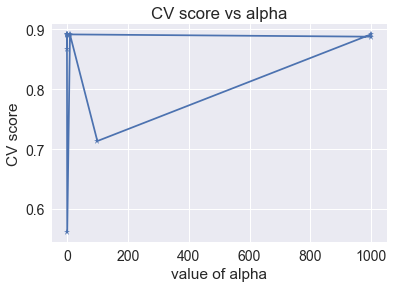


The accuracy of the lr for c = 10 is 87.517564%

The f1 score of the lr for c = 10 is 72.734205%

The recall score of the lr for c = 10 is 69.564717%

The precision score of the lr for c = 10 is 78.753114%


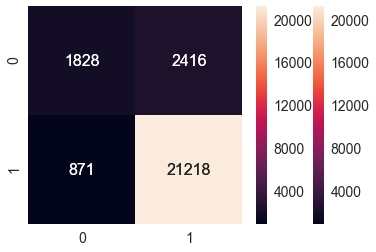

In [163]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
clf = LogisticRegression(C= 1000, penalty= 'l1')
clf.fit(X_train,y_train)
pred = clf.predict(x_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
f1=f1_score(y_test, pred,average= 'macro')*100
r=recall_score(y_test, pred,average= 'macro')*100
p=precision_score(y_test, pred,average= 'macro')*100
    
c=[1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001,1000]    
scores =gsv.cv_results_['mean_test_score']
plt.plot(c, scores, marker = '*') 
plt.title("CV score vs alpha")
plt.xlabel('value of alpha')
plt.ylabel('CV score')
plt.show()
print('\nThe accuracy of the lr for c = %d is %f%%' % (10, acc))
print('\nThe f1 score of the lr for c = %d is %f%%' % (10, f1))
print('\nThe recall score of the lr for c = %d is %f%%' % (10, r))
print('\nThe precision score of the lr for c = %d is %f%%' % (10, p))
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [164]:
w2v_words = list(w2v_model.wv.vocab)
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1  

In [165]:
X_train = tfidf_sent_vectors

In [166]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1  

In [167]:
x_test = tfidf_sent_vectors_test
X_train = np.nan_to_num(X_train)
x_test = np.nan_to_num(x_test)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  1.0min finished


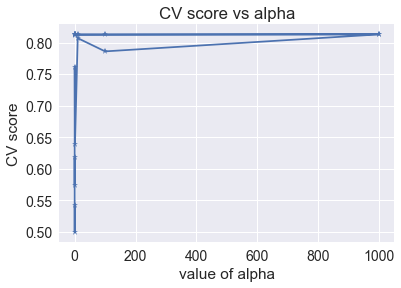

Best HyperParameter:  {'C': 1, 'penalty': 'l2'}
Best Auc score: 80.68%


In [168]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=3) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='roc_auc')
gsv.fit(X_train,y_train)
c=[1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001,1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]    
scores =gsv.cv_results_['mean_train_score']
plt.plot(c, scores, marker = '*') 
plt.title("CV score vs alpha")
plt.xlabel('value of alpha')
plt.ylabel('CV score')
plt.show()
print("Best HyperParameter: ",gsv.best_params_)
print("Best Auc score: %.2f%%"%(gsv.best_score_*100))

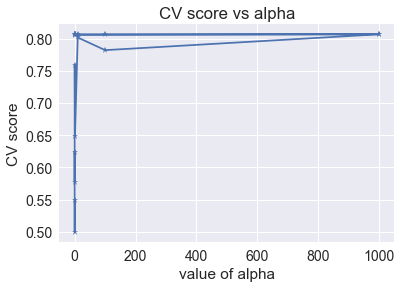


The accuracy of the lr for c = 1000 is 84.863100%

The f1 score of the lr for c = 1000 is 59.744876%

The recall score of the lr for c = 1000 is 57.941236%

The precision score of the lr for c = 1000 is 73.078237%


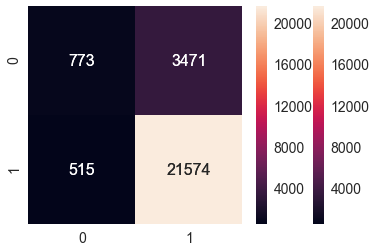

In [169]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
clf = LogisticRegression(C= 1000, penalty= 'l1')
clf.fit(X_train,y_train)
pred = clf.predict(x_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
f1=f1_score(y_test, pred,average= 'macro')*100
r=recall_score(y_test, pred,average= 'macro')*100
p=precision_score(y_test, pred,average= 'macro')*100
c=[1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001,1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]    
scores =gsv.cv_results_['mean_test_score']
plt.plot(c, scores, marker = '*') 
plt.title("CV score vs alpha")
plt.xlabel('value of alpha')
plt.ylabel('CV score')
plt.show()    

print('\nThe accuracy of the lr for c = %d is %f%%' % (1000, acc))
print('\nThe f1 score of the lr for c = %d is %f%%' % (1000, f1))
print('\nThe recall score of the lr for c = %d is %f%%' % (1000, r))
print('\nThe precision score of the lr for c = %d is %f%%' % (1000, p))
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   28.8s finished


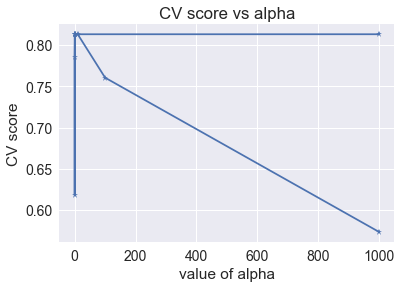

Best HyperParameter:  {'penalty': 'l2', 'C': 0.5}
Best Auc score: 80.68%


In [170]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = { 'C':[1000,100,10,1,0.5,0.1,0.01,0.001,0.0001],
              'penalty':['l1','l2']}

tscv = TimeSeriesSplit(n_splits=3) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='roc_auc')
gsv.fit(X_train,y_train)
c=[1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001,1000]    
scores =gsv.cv_results_['mean_train_score']
plt.plot(c, scores, marker = '*') 
plt.title("CV score vs alpha")
plt.xlabel('value of alpha')
plt.ylabel('CV score')
plt.show()
print("Best HyperParameter: ",gsv.best_params_)
print("Best Auc score: %.2f%%"%(gsv.best_score_*100))

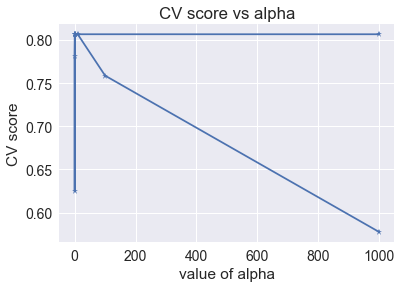


The accuracy of the lr for c = 1 is 84.847909%

The f1 score of the lr for c = 1 is 59.678744%

The recall score of the lr for c = 1 is 57.894111%

The precision score of the lr for c = 1 is 73.009078%


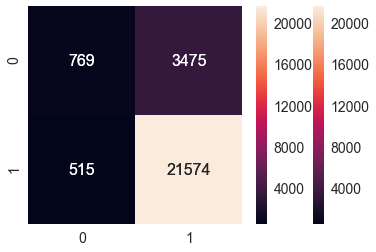

In [171]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
clf = LogisticRegression(C= 1, penalty= 'l2')
clf.fit(X_train,y_train)
pred = clf.predict(x_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
f1=f1_score(y_test, pred,average= 'macro')*100
r=recall_score(y_test, pred,average= 'macro')*100
p=precision_score(y_test, pred,average= 'macro')*100
c=[1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001,1000]    
scores =gsv.cv_results_['mean_test_score']
plt.plot(c, scores, marker = '*') 
plt.title("CV score vs alpha")
plt.xlabel('value of alpha')
plt.ylabel('CV score')
plt.show()    

print('\nThe accuracy of the lr for c = %d is %f%%' % (1, acc))
print('\nThe f1 score of the lr for c = %d is %f%%' % (1, f1))
print('\nThe recall score of the lr for c = %d is %f%%' % (1, r))
print('\nThe precision score of the lr for c = %d is %f%%' % (1, p))
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [172]:
import sys
sys.path.append('c://users/melvi/appdata/local/programs/python/python36/lib/site-packages')

from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model", "Hyper parameter", "accuracy", "f1 score","recall","precision score"]
x.add_row(["BOW", 0.1,90.26,81.40,79.91,83.19])
x.add_row(["RANDOM SEARCH BOW", 0.1,90.28,81.46,79.98,83.22])
x.add_row(["TFIDF", 10,91.13,82.58,80.19,85.73])
x.add_row(["RANDOM SEARCH TFIDF",10,91.13,82.58,80.19,85.73])
x.add_row(["AVGW2V", 1000,86.54,70.39,67.21,77.44])
x.add_row(["RANDOM SEARCH AVGW2V", 1000,86.52,70.32,67.13,77.43])
x.add_row(["TFIDFW2V", 1000, 83.43,45.48,50.00,41.71])
x.add_row(["RANDOM SEARCH TFIDFW2V", 1, 83.43,45.48,50.00,41.71])
print(x)


+------------------------+-----------------+----------+----------+--------+-----------------+
|         Model          | Hyper parameter | accuracy | f1 score | recall | precision score |
+------------------------+-----------------+----------+----------+--------+-----------------+
|          BOW           |       0.1       |  90.26   |   81.4   | 79.91  |      83.19      |
|   RANDOM SEARCH BOW    |       0.1       |  90.28   |  81.46   | 79.98  |      83.22      |
|         TFIDF          |        10       |  91.13   |  82.58   | 80.19  |      85.73      |
|  RANDOM SEARCH TFIDF   |        10       |  91.13   |  82.58   | 80.19  |      85.73      |
|         AVGW2V         |       1000      |  86.54   |  70.39   | 67.21  |      77.44      |
|  RANDOM SEARCH AVGW2V  |       1000      |  86.52   |  70.32   | 67.13  |      77.43      |
|        TFIDFW2V        |       1000      |  83.43   |  45.48   |  50.0  |      41.71      |
| RANDOM SEARCH TFIDFW2V |        1        |  83.43   |  45.

In [173]:
import sys
sys.path.append('c://users/melvi/appdata/local/programs/python/python36/lib/site-packages')
from wordcloud import WordCloud
